In [29]:
# Read data and EDA
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import numpy as np
import seaborn as sns
from wordcloud import WordCloud

# Preparation and Evaluation
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

# Model Implementation
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Dense, Dropout,Embedding, LSTM, TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [2]:
train_data = pd.read_csv("/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv")
train_data = train_data.rename(columns={'label': 'generated', 'prompt_name': 'prompt_id'}, errors='ignore')
train_data

,text,generated,prompt_id,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False
...,...,...,...,...,...
44863,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44864,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44865,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44866,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True


In [3]:
test_essay = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/test_essays.csv")
test_essay

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [4]:
sample_sub = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv")
sample_sub

,id,generated
0,0000aaaa,0.1
1,1111bbbb,0.9
2,2222cccc,0.4


## EDA

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44868 entries, 0 to 44867
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           44868 non-null  object
 1   generated      44868 non-null  int64 
 2   prompt_id      44868 non-null  object
 3   source         44868 non-null  object
 4   RDizzl3_seven  44868 non-null  bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 1.4+ MB


In [7]:
train_data.head(10)

,text,generated,prompt_id,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False
5,Cell phone use should not be legal while drivi...,0,Phones and driving,persuade_corpus,False
6,Phones and Driving\n\nDriving is a good way to...,0,Phones and driving,persuade_corpus,False
7,PHONES AND DRIVING\n\nIn this world in which w...,0,Phones and driving,persuade_corpus,False
8,People are debating whether if drivers should ...,0,Phones and driving,persuade_corpus,False
9,Texting and driving\n\nOver half of drivers in...,0,Phones and driving,persuade_corpus,False


In [8]:
train_data.describe()

,generated
count,44868.000000
mean,0.389966
std,0.487748
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


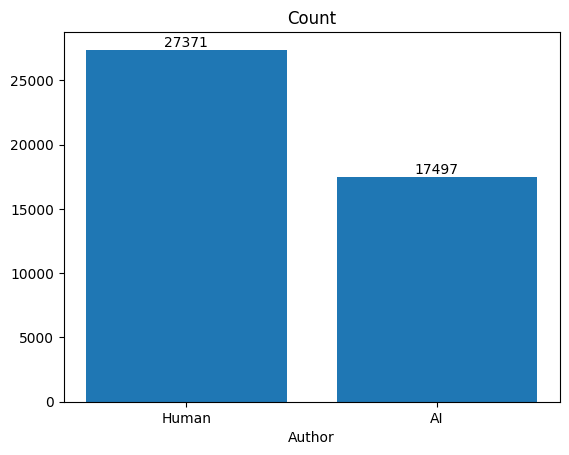

In [9]:
human_ai_count = train_data['generated'].value_counts().reset_index()
human_ai_count['generated'] = human_ai_count['generated'].replace({0: 'Human', 1: 'AI'})
plt.bar(human_ai_count['generated'], human_ai_count['count'])
plt.xlabel('Author')
plt.title(f'Count')
[plt.text(lbl, count, count, ha="center", va="bottom") for (lbl, count) in human_ai_count.to_numpy()]
plt.show()

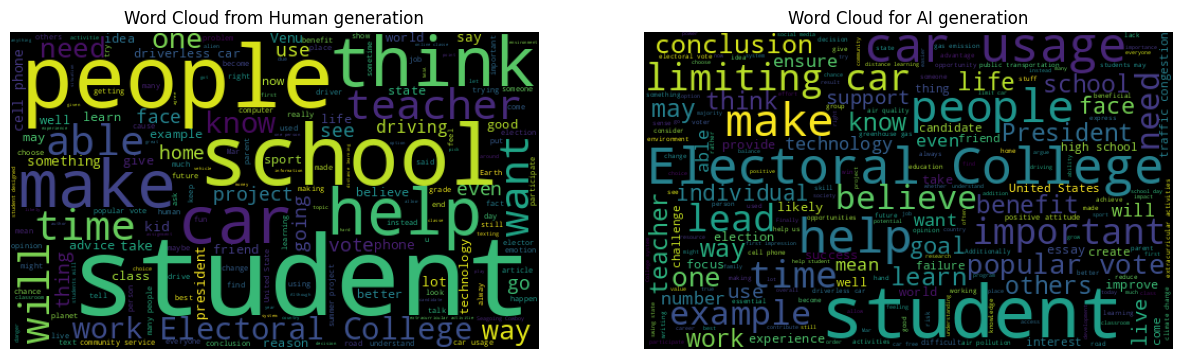

In [10]:
# Convert all articles into single string
word_cloud_0 = train_data.query('generated == 0')['text'].str.cat(sep=" ")
word_cloud_0 = WordCloud(width=500, height=300).generate(word_cloud_0)
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(word_cloud_0)
plt.title('Word Cloud from Human generation')
plt.axis("off")

plt.subplot(1, 2, 2)
word_cloud_1 = train_data.query('generated == 1')['text'].str.cat(sep=" ")
word_cloud_1 = WordCloud(width=500, height=300).generate(word_cloud_1)
plt.imshow(word_cloud_1)
plt.title('Word Cloud for AI generation')
plt.axis("off")

plt.show()

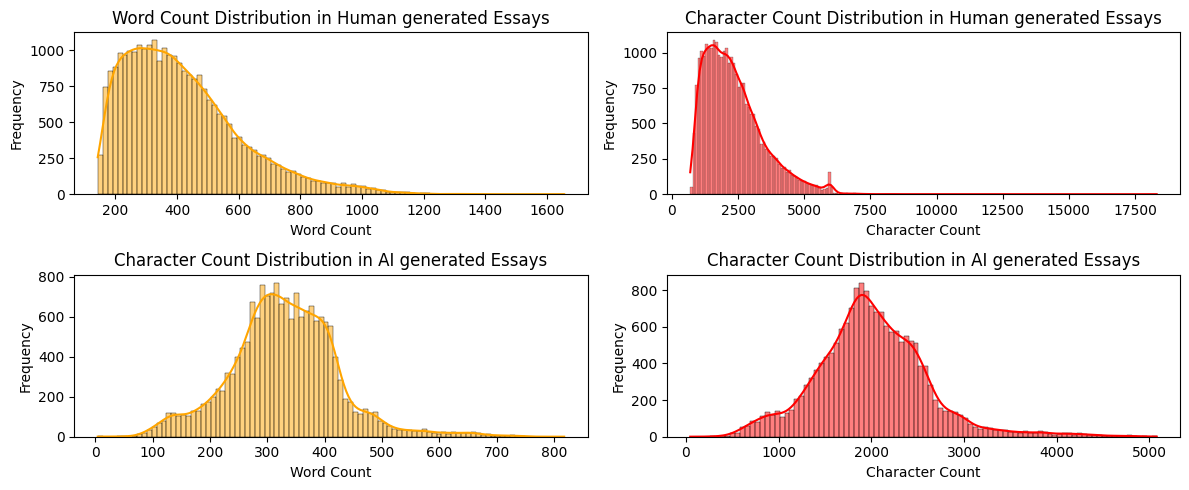

In [11]:
def show_hist_plot(series, title, xlabel, ylabel, color):
    sns.histplot(series, kde=True, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

train_data['word_count'] = train_data['text'].apply(lambda x: len(x.split()))
train_data['char_count'] = train_data['text'].apply(len)

plt.figure(figsize=(12, 5))

plt.subplot(2, 2, 1)
show_hist_plot(train_data.query('generated == 0')['word_count'], 'Word Count Distribution in Human generated Essays', 'Word Count', 'Frequency', 'orange')

plt.subplot(2, 2, 2)
show_hist_plot(train_data.query('generated == 0')['char_count'], 'Character Count Distribution in Human generated Essays', 'Character Count', 'Frequency', 'red')

plt.subplot(2, 2, 3)
show_hist_plot(train_data.query('generated == 1')['word_count'], 'Character Count Distribution in AI generated Essays', 'Word Count', 'Frequency', 'orange')

plt.subplot(2, 2, 4)
show_hist_plot(train_data.query('generated == 1')['char_count'], 'Character Count Distribution in AI generated Essays', 'Character Count', 'Frequency', 'red')

plt.tight_layout()
plt.show()

## Data Preprocessing

In [14]:
max_len = 512

vectorize_layer = TextVectorization(output_sequence_length=max_len)
# Adapt only the vocabularies from the original training dataset
vectorize_layer.adapt(train_data.query("source == 'train_essays'").query("generated == 0")['text'])

In [15]:
train_vectorized_text = vectorize_layer(train_data['text']).numpy()
train_vectorized_text[:10]

array([[2480,  815,  716, ...,    0,    0,    0],
       [  19, 1749,   39, ...,    0,    0,    0],
       [  68,  211,    2, ...,    0,    0,    0],
       ...,
       [2480,    6,   68, ...,    0,    0,    0],
       [  14,   12, 4446, ..., 3094,  676,  117],
       [2655,    6,   68, ...,    0,    0,    0]])

In [16]:
train_vectorized_text.shape

(44868, 512)

## Splitting data for train and validation

In [18]:
x_train, x_val, y_train, y_val = train_test_split(train_vectorized_text, train_data['generated'], test_size=0.2, shuffle=True)

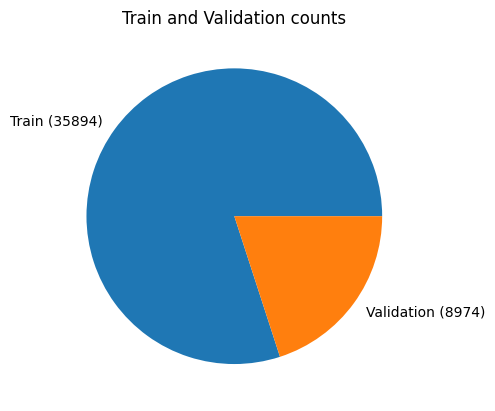

In [19]:
counts = [x_train.shape[0], x_val.shape[0]]
plt.pie(counts, labels=[f'Train ({counts[0]})', f'Validation ({counts[1]})'])
plt.title('Train and Validation counts')
plt.show()

In [20]:
y_train_np = y_train.values
y_val_np = y_val.values

In [21]:
max_words = len(vectorize_layer.get_vocabulary())

## Bi-LSTM

In [22]:
from tensorflow.keras.layers import LSTM

def bi_lstm_model(max_words, max_len):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=1000, input_length=max_len))
    model.add(Bidirectional(LSTM(100)))  # Using LSTM instead of SimpleRNN
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(units=1, activation='sigmoid'))
    return model

# Set the maximum number of words and maximum sequence length
# max_words = 6000  # This should match the number you used in your tokenizer
# max_len = 1000     # This should match the length you've used for padding sequences

# Create and compile the Bi-LSTM model
model = bi_lstm_model(max_words, max_len)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Display the model's architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 1000)         17403000  
                                                                 
 bidirectional (Bidirection  (None, 200)               880800    
 al)                                                             
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 18304001 (69.82 MB)
Trainable params: 18304001 (69.82 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [23]:
EPOCHS = 3
BATCH_SIZE = 64
model.fit(x_train, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val_np))

Epoch 1/3
561/561 [==============================] - 118s 198ms/step - loss: 0.1615 - accuracy: 0.9464 - val_loss: 0.1750 - val_accuracy: 0.9334
Epoch 2/3
561/561 [==============================] - 74s 133ms/step - loss: 0.1321 - accuracy: 0.9560 - val_loss: 0.1207 - val_accuracy: 0.9483
Epoch 3/3
561/561 [==============================] - 63s 112ms/step - loss: 0.0400 - accuracy: 0.9880 - val_loss: 0.0296 - val_accuracy: 0.9905


In [24]:
loss, acc = model.evaluate(x_val, y_val_np)

281/281 [==============================] - 9s 32ms/step - loss: 0.0296 - accuracy: 0.9905


In [25]:
print("Loss on validation data is:", loss)
print("Accuracy on validation data:", acc)

Loss on validation data is: 0.029600363224744797
Accuracy on validation data: 0.9905281662940979


In [26]:
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)

281/281 [==============================] - 8s 30ms/step


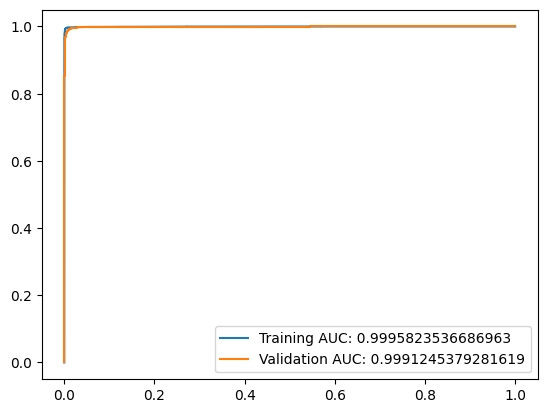

In [30]:
fpr_train, tpr_train, _ = roc_curve(y_train_np, y_train_pred)
auc_train = roc_auc_score(y_train_np, y_train_pred)
plt.plot(fpr_train, tpr_train ,label=f"Training AUC: {auc_train}")

fpr_val, tpr_val, _ = roc_curve(y_val_np, y_val_pred)
auc_val = roc_auc_score(y_val_np, y_val_pred)
plt.plot(fpr_val, tpr_val, label=f"Validation AUC: {auc_val}")

plt.legend()
plt.show()

getting the output / prediction on model-1

In [31]:
test_vectorized_text = vectorize_layer(test_essay['text']).numpy()
test_vectorized_text.shape

(3, 512)

In [32]:
y_pred = model.predict(test_vectorized_text)
y_pred

1/1 [==============================] - 0s 30ms/step


array([[0.954514],
       [0.954514],
       [0.954514]], dtype=float32)

In [33]:
final_submission = pd.DataFrame({'id': test_essay['id'], 'generated': [y[0] for y in y_pred]})
final_submission.to_csv('submission_kag_model1.csv', index=False)

In [35]:
model.save('model1.h5')


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
# ChatGPT 3.5 Generated paragraphs on prompt ID 0
gpt_text = 'In our rapidly evolving world, the convenience of personal automobiles has become deeply ingrained in our daily lives. However, it is essential to consider the broader implications of our reliance on cars, not just for individual comfort but also for the collective well-being of our society and the environment. This essay explores the advantages of limiting car usage, drawing insights from multiple sources to underscore the importance of embracing alternative transportation methods for a sustainable future.'
gpt_text_2 = 'One significant advantage of reducing car usage lies in the realm of environmental preservation. According to a report by the Environmental Protection Agency (EPA), the transportation sector is a major contributor to air pollution and greenhouse gas emissions. Cars emit pollutants that degrade air quality, leading to respiratory problems and other health issues. By limiting car usage and promoting alternatives such as public transportation, cycling, and walking, we can collectively reduce our carbon footprint and mitigate the impact of climate change.'
gpt_text_3 = 'Furthermore, limiting car usage can have profound positive effects on traffic congestion and urban planning. A study conducted by the Urban Land Institute reveals that the overreliance on cars contributes to congested roadways, leading to increased travel times and economic inefficiencies. Implementing measures to limit car usage, such as developing comprehensive public transportation systems and promoting carpooling, can alleviate traffic congestion, making cities more livable and efficient.'

# BBC news articles
bbc_text = 'Those alleged conversations were outlined in an indictment unsealed by US prosecutors on Wednesday. The US Justice Department has charged Mr Gupta with an elaborate plot to assassinate a dual US-Canadian citizen based in New York, a plot allegedly directed by an Indian government employee.'
bbc_text_1 = 'In the Paris Agreement itself, the baseline for pre-industrial measures wasn\'t defined. But the International Panel on Climate Change uses a baseline of 1850-1900. That\'s because it\'s the earliest period with reliable, near-global measurements. It\'s true that some warming from human activity had already occurred by that point, because the industrial revolution began in the early 1700s. But having good historical data for a reliable baseline is crucial to measure changes happening today.'
bbc_text_2 = 'The room bustled with the din of volunteer waitstaff and diners amid a jazzy soundtrack playing overhead. A knife suddenly clanged against the floor. No one seemed to hear it except for renowned, three-Michelin starred chef Massimo Bottura, who instinctively ran over to pick it up, gave the diner a new utensil and initiated a warm, friendly chat to ensure he was enjoying his meal. With Bottura, the patrons at this church hall are given the same level of hospitality as those at his high-end restaurants like the famed Osteria Francescana and the newly opened Al Gatto Verde in Modena, Italy.'

extra_texts = [gpt_text, gpt_text_2, gpt_text_3, bbc_text, bbc_text_1, bbc_text_2]
extra_texts = pd.DataFrame({'text': extra_texts, 'generated': [1, 1, 1, 0, 0, 0]})
extra_vectorized_text = vectorize_layer(extra_texts['text']).numpy()
model.evaluate(extra_vectorized_text, extra_texts['generated'])

1/1 [==============================] - 1s 970ms/step - loss: 0.6806 - accuracy: 0.8333


[0.6805567741394043, 0.8333333134651184]

In [37]:
daigt = pd.read_csv("/kaggle/input/daigt-external-dataset/daigt_external_dataset.csv")

In [38]:
daigt_human = pd.DataFrame({'text': daigt['text'], 'generated': 0})
daigt_ai = pd.DataFrame({'text': daigt['source_text'], 'generated': 1})
daigt_data = pd.concat([daigt_human, daigt_ai], ignore_index=True)
daigt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4842 entries, 0 to 4841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       4842 non-null   object
 1   generated  4842 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 75.8+ KB


In [39]:
daigt_vectorized_text = vectorize_layer(daigt_data['text']).numpy()
model.evaluate(daigt_vectorized_text, daigt_data['generated'].values)

152/152 [==============================] - 5s 32ms/step - loss: 0.5465 - accuracy: 0.8432


[0.546539306640625, 0.843246579170227]

152/152 [==============================] - 4s 30ms/step


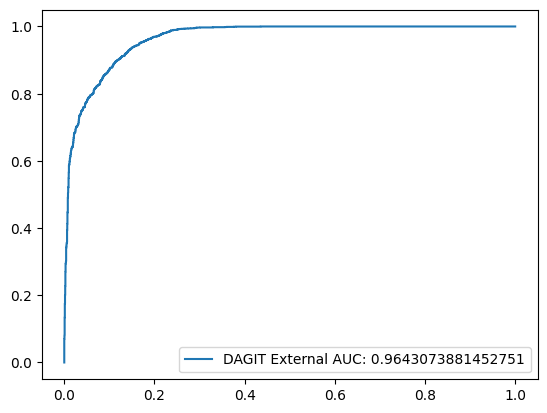

In [40]:
y_daigt_pred = model.predict(daigt_vectorized_text)

fpr_daigt, tpr_daigt, _ = roc_curve(daigt_data['generated'].values, y_daigt_pred)
auc_daigt = roc_auc_score(daigt_data['generated'].values, y_daigt_pred)
plt.plot(fpr_daigt, tpr_daigt, label=f"DAGIT External AUC: {auc_daigt}")
plt.legend()
plt.show()

trying another model with few updates : 


In [41]:
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

def bi_lstm_model(max_words, max_len):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=256, input_length=max_len))  # Reduced output_dim
    model.add(Bidirectional(LSTM(64, dropout=0.2)))  # Reduced LSTM units and increased dropout
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))  # Reduced Dense units and added L2 regularization
    model.add(Dropout(0.5))  # Increased dropout after Dense layer
    model.add(Dense(units=1, activation='sigmoid'))
    return model

model2 = bi_lstm_model(max_words, max_len)
model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 512, 256)          4455168   
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4627841 (17.65 MB)
Trainable params: 4627841 (17.65 MB)
Non-trainable params: 0 (0.00 Byte)
______________

Add Dropout: Dropout is a regularization technique that involves randomly setting a fraction of input units to 0 at each update during training, which helps prevent overfitting. You can increase the dropout rate in your LSTM layer and after the Dense layer.

L2 Regularization: Add L2 weight regularization to your Dense layers. This penalizes large weights and effectively simplifies the model, which can help with overfitting.

Reduce Model Complexity: If your model is too complex, it might overfit. You can try reducing the number of units in your LSTM and Dense layers.

Early Stopping: Use Early Stopping during training. This stops training when a monitored metric has stopped improving.

Reduce Embedding Output Dimension: A very high-dimensional embedding can lead to overfitting, especially if you don't have a lot of training data. You might want to experiment with reducing the output dimension of the Embedding layer.

In [42]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Assuming you have already defined EPOCHS and BATCH_SIZE
EPOCHS = 3
BATCH_SIZE = 64

# Fit the model with early stopping callback
model2.fit(
    x_train, 
    y_train_np, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_data=(x_val, y_val_np), 
    callbacks=[early_stopping]
)


Epoch 1/3
561/561 [==============================] - 97s 166ms/step - loss: 0.1986 - accuracy: 0.9388 - val_loss: 0.0905 - val_accuracy: 0.9805
Epoch 2/3
561/561 [==============================] - 53s 94ms/step - loss: 0.0602 - accuracy: 0.9880 - val_loss: 0.0514 - val_accuracy: 0.9885
Epoch 3/3
561/561 [==============================] - 45s 81ms/step - loss: 0.0431 - accuracy: 0.9909 - val_loss: 0.1362 - val_accuracy: 0.9525


In [43]:
loss2, acc2 = model2.evaluate(x_val, y_val_np)

281/281 [==============================] - 6s 22ms/step - loss: 0.1362 - accuracy: 0.9525


In [44]:
print("Loss on validation data is:", loss2)
print("Accuracy on validation data:", acc2)

Loss on validation data is: 0.13618746399879456
Accuracy on validation data: 0.9525295495986938


In [45]:
y_train_pred2 = model2.predict(x_train)
y_val_pred2 = model2.predict(x_val)

281/281 [==============================] - 5s 19ms/step


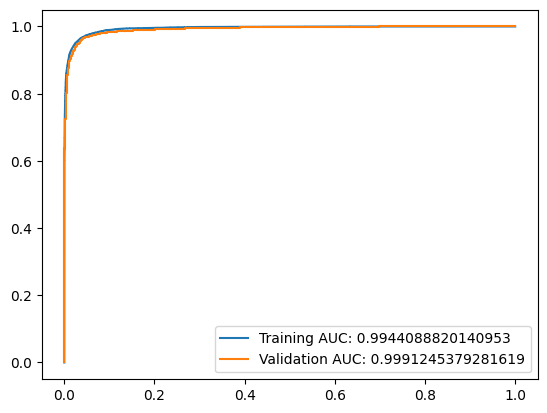

In [46]:
fpr_train2, tpr_train2, _ = roc_curve(y_train_np, y_train_pred2)
auc_train2 = roc_auc_score(y_train_np, y_train_pred2)
plt.plot(fpr_train2, tpr_train2 ,label=f"Training AUC: {auc_train2}")

fpr_val2, tpr_val2, _ = roc_curve(y_val_np, y_val_pred2)
auc_val2 = roc_auc_score(y_val_np, y_val_pred2)
plt.plot(fpr_val2, tpr_val2, label=f"Validation AUC: {auc_val}")

plt.legend()
plt.show()

## test data prep and evaluation

In [47]:
y_pred2 = model2.predict(test_vectorized_text)
y_pred

1/1 [==============================] - 0s 29ms/step


array([[0.954514],
       [0.954514],
       [0.954514]], dtype=float32)

In [48]:
final_submission = pd.DataFrame({'id': test_essay['id'], 'generated': [y[0] for y in y_pred2]})
final_submission.to_csv('submission_kag_model2.csv', index=False)

In [49]:
#save the model and its weights: model-2
model2.save('model2.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Test Essay Preprocessing and  Prediction 

In [50]:
model2.evaluate(daigt_vectorized_text, daigt_data['generated'].values)

152/152 [==============================] - 3s 21ms/step - loss: 0.5256 - accuracy: 0.7831


[0.5256147980690002, 0.7831474542617798]

152/152 [==============================] - 3s 19ms/step


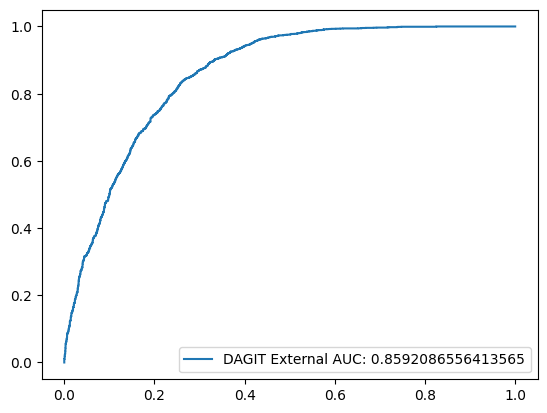

In [51]:
y_daigt_pred2 = model2.predict(daigt_vectorized_text)

fpr_daigt2, tpr_daigt2, _ = roc_curve(daigt_data['generated'].values, y_daigt_pred2)
auc_daigt2 = roc_auc_score(daigt_data['generated'].values, y_daigt_pred2)
plt.plot(fpr_daigt2, tpr_daigt2, label=f"DAGIT External AUC: {auc_daigt2}")
plt.legend()
plt.show()

## model-3

In [52]:
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', 
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)


In [53]:
def simplified_lstm_attention_model(max_words, max_len):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=300, input_length=max_len))
    model.add(Bidirectional(LSTM(50, return_sequences=True)))
    model.add(AttentionLayer())
    model.add(Dense(50, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation='sigmoid'))
    return model

# Create and compile the simplified model
model3 = simplified_lstm_attention_model(max_words, max_len)
model3.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model3.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 512, 300)          5220900   
                                                                 
 bidirectional_2 (Bidirecti  (None, 512, 100)          140400    
 onal)                                                           
                                                                 
 attention_layer (Attention  (None, 100)               612       
 Layer)                                                          
                                                                 
 dense_4 (Dense)             (None, 50)                5050      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [55]:
model3.fit(x_train, y_train_np, epochs=3, batch_size=64, 
                     validation_data=(x_val, y_val_np), callbacks=[early_stopping])


Epoch 1/3
561/561 [==============================] - 102s 173ms/step - loss: 0.1947 - accuracy: 0.9616 - val_loss: 0.0495 - val_accuracy: 0.9901
Epoch 2/3
561/561 [==============================] - 51s 91ms/step - loss: 0.0334 - accuracy: 0.9932 - val_loss: 0.0542 - val_accuracy: 0.9844
Epoch 3/3
561/561 [==============================] - 47s 83ms/step - loss: 0.0238 - accuracy: 0.9951 - val_loss: 0.0322 - val_accuracy: 0.9915


In [56]:
loss3, acc3 = model3.evaluate(x_val, y_val_np)

281/281 [==============================] - 7s 24ms/step - loss: 0.0322 - accuracy: 0.9915


In [57]:
print("Loss on validation data is:", loss3)
print("Accuracy on validation data:", acc3)

Loss on validation data is: 0.032242171466350555
Accuracy on validation data: 0.9915310740470886


In [58]:
model3.save('simplified_lstm_attention_model')


In [59]:
y_train_pred3 = model3.predict(x_train)
y_val_pred3 = model3.predict(x_val)

281/281 [==============================] - 6s 22ms/step


In [60]:
# from tensorflow.keras.models import load_model
# from sklearn.metrics import RocCurveDisplay
# # Ensure that your custom AttentionLayer class is also imported here


# # Or if it was saved using the SavedModel format
# restored_model = load_model('simplified_lstm_attention_model', custom_objects={'AttentionLayer': AttentionLayer})

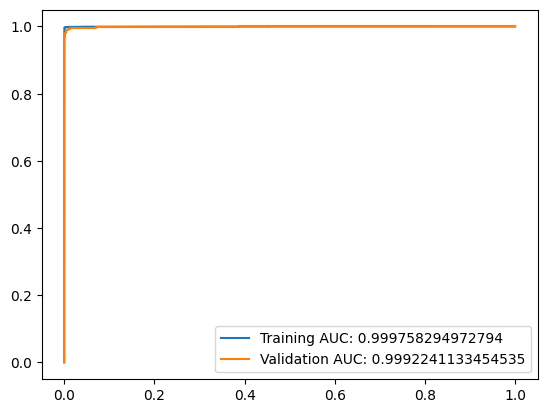

In [61]:
fpr_train3, tpr_train3, _ = roc_curve(y_train_np, y_train_pred3)
auc_train3 = roc_auc_score(y_train_np, y_train_pred3)
plt.plot(fpr_train3, tpr_train3, label=f"Training AUC: {auc_train3}")

fpr_val3, tpr_val3, _ = roc_curve(y_val_np, y_val_pred3)
auc_val3 = roc_auc_score(y_val_np, y_val_pred3)
plt.plot(fpr_val3, tpr_val3, label=f"Validation AUC: {auc_val3}")

plt.legend()
plt.show()

In [62]:
y_pred3 = model3.predict(test_vectorized_text)
y_pred

1/1 [==============================] - 0s 30ms/step


array([[0.954514],
       [0.954514],
       [0.954514]], dtype=float32)

In [63]:
final_submission = pd.DataFrame({'id': test_essay['id'], 'generated': [y[0] for y in y_pred3]})
final_submission.to_csv('submission_kag_with attentionlayer.csv', index=False)

In [64]:
model3.evaluate(daigt_vectorized_text, daigt_data['generated'].values)

152/152 [==============================] - 4s 23ms/step - loss: 0.7834 - accuracy: 0.8203


[0.7833725214004517, 0.8203221559524536]

152/152 [==============================] - 3s 21ms/step


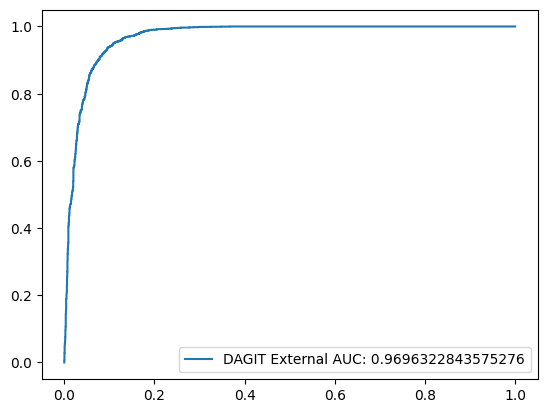

In [65]:
y_daigt_pred3 = model3.predict(daigt_vectorized_text)

fpr_daigt3, tpr_daigt3, _ = roc_curve(daigt_data['generated'].values, y_daigt_pred3)
auc_daigt3 = roc_auc_score(daigt_data['generated'].values, y_daigt_pred3)
plt.plot(fpr_daigt3, tpr_daigt3, label=f"DAGIT External AUC: {auc_daigt3}")
plt.legend()
plt.show()